In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# ! pip install statsmodels

## Importing Libraries

In [62]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet
import statsmodels.api as sm
from itertools import product
from keras.layers import LSTM
from tqdm.notebook import tqdm
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.utils import np_utils
import statsmodels.tsa.api as smt
from keras.models import Sequential
from xgboost.sklearn import XGBRegressor
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [63]:
# Importing dataset from the Google Drive
train_df = pd.read_csv("/content/drive/MyDrive/Time Series /Weather Forecasting Dataset from Kaggle/DailyDelhiClimateTrain.csv")

In [64]:
print(train_df.shape)
print(train_df.columns)

(1462, 5)
Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')


In [65]:
# Checking wether the dataset contains any null value
print(train_df.isna().sum())

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [66]:
print(train_df.date) # Checking the date format

0       2013-01-01
1       2013-01-02
2       2013-01-03
3       2013-01-04
4       2013-01-05
           ...    
1457    2016-12-28
1458    2016-12-29
1459    2016-12-30
1460    2016-12-31
1461    2017-01-01
Name: date, Length: 1462, dtype: object


In [67]:
# Defined a function to convert the daily records to monthly records and converting the a multivariate time series to univariate time series dataset
def monthly_avg_temperature(data):
  monthly_temp_df = data.copy()
  monthly_temp_df.date = monthly_temp_df.date.apply(lambda x: str(x)[:-3]) # Extracting the year and month from the date feature
  monthly_temp = monthly_temp_df.groupby("date").mean().reset_index() # Generating a new dataset with monthly mean temperature
  monthly_temp.date = pd.to_datetime(monthly_temp.date) # Converting again back to datetime format
  monthly_temp = monthly_temp.drop(['humidity', 'wind_speed', 'meanpressure'], axis='columns') # Since the objective is to forecast the monthly mean temperature therefore removing other un-imporatnt features.

  return monthly_temp

In [68]:
df = monthly_avg_temperature(train_df[:-1])
df = df[1:]
df.shape

(47, 2)

In [69]:
# Setting an index as Date
df = df.set_index('date')
df

,meantemp
date,
2013-02-01,16.867560
2013-03-01,22.814209
2013-04-01,28.895119
2013-05-01,33.776767
2013-06-01,32.480873
2013-07-01,30.663594
2013-08-01,29.547773
2013-09-01,29.840595
2013-10-01,26.129186


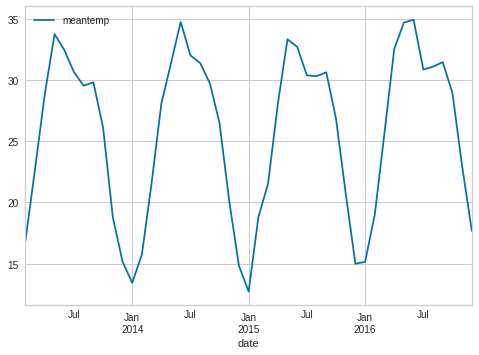

In [70]:
# Plotting the monthly dataset to check wether it contains seasonality or it is a non-seasonal data along with the trend
df.plot()

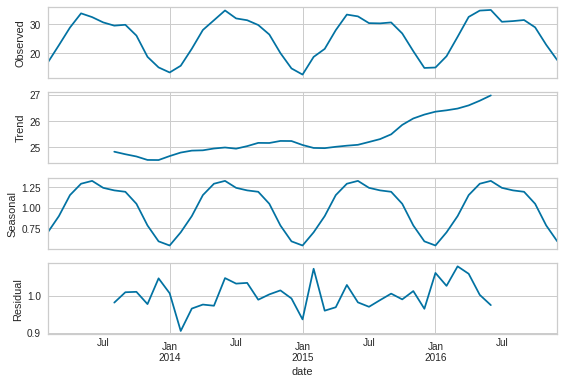

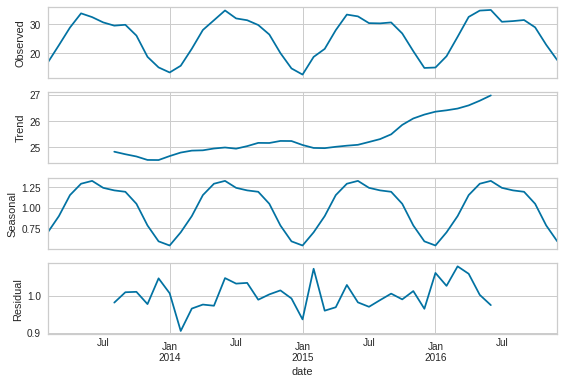

In [71]:
# Since from the above plot it can be clearly observed that the data contains seasonality.
# hence further understanding the seasonality using Seasonal Decompose method.
# Seasonal Decompose contains 2 types of model "additive" and "multiplicative"
# The time series is "Additive" -> If the increasing or decreasing pattern of the time series is similar throughout the series,
# where as the time series having exponential growth or decrement with time then the time series can be considered as the "Multiplicative" time series.
seasonal_decompose(df, model='multiplicative', freq=12).plot()

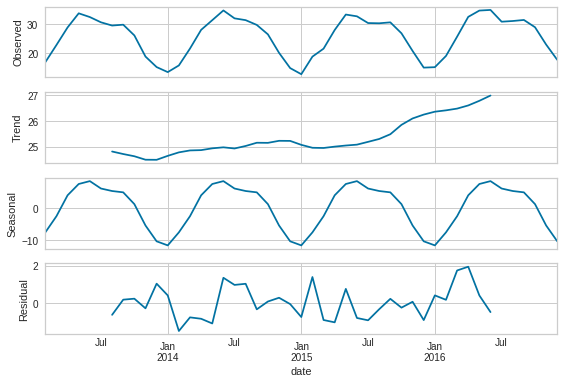

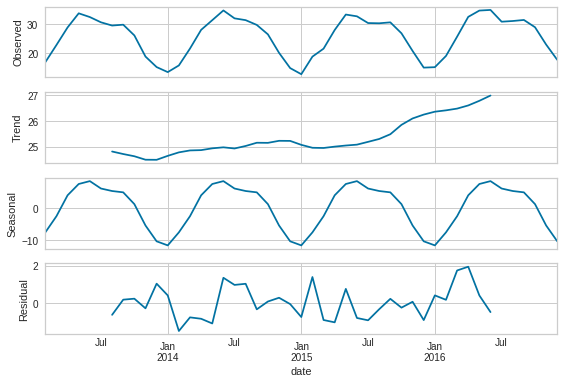

In [72]:
# By visualisation it is observed that the increasing trend is simillar through out, hence "Additive" model to be considered.
seasonal_decompose(df, model='additive', freq=12).plot()

In [73]:
df.isna().sum()

meantemp    0
dtype: int64

## Checking the Stationarity on the timeseries data

In [74]:
## Augmented Dickey Fuller Test (ADF Test)
# Ho: It is non stationary
# H1: It is stationary
def adfuller_test(data):
  df = data.copy()
  df.dropna(inplace=True)
  result = adfuller(df[df.columns[-1]], autolag='AIC')
  labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations Used']

  global number_of_lags 
  number_of_lags = result[2]

  for value,label in zip(result,labels):
    print(label+' : '+str(value))

  if result[1] <= 0.05:
    print("\n--> Strong evidence against the Null Hypothesis(Ho),\n--> Reject the Null Hypothesis.\n--> Data has no Unit Root and is Stationary\n")
  else:
    print("\n--> Strong evidence against the Alternate Hypothesis(H1),\n--> Reject the Alternate Hypothesis.\n--> Data has Unit Root and is Non-Stationary\n")

## Kwiatkowski Phillips Schmidt Shin (KPSS Test)
# Ho: It is stationary
# H1: It is non stationary
def kpss_test(timeseries):
  print("Results of KPSS Test:")
  kpss_timeseries = np.squeeze(timeseries).shape
  kpsstest = kpss(kpss_timeseries, regression="c", lags="auto")
  kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])

  for key, value in kpsstest[3].items():
      kpss_output["Critical Value (%s)" % key] = value

  print(kpss_output)

  if kpss_output[1] <= 0.05:
    print("\n--> Strong evidence against the Null Hypothesis(Ho),\n--> Reject the Null Hypothesis.\n--> Data has Unit Root and Trend is Non-Stationary\n")
  else:
    print("\n--> Strong evidence against the Alternate Hypothesis(H1),\n--> Reject the Alternate Hypothesis.\n--> Data has no Unit Root and Trend is Stationary\n")

# Differencing function to make the data Stationary
def get_diff(data, count, prophet_df=False):
  df = data.copy()
  count += 1
  column_name = 'temp_diff_' + str(count)
  df[column_name] = df[df.columns[-1]].diff()
  if prophet_df:
    df = df.drop('meantemp', inplace=True, axis='columns')
    return df
  else:
    df = df.drop(df.columns[0], axis='columns')

  return df.dropna()

# ACF & PACF plotting graph function to check the Order of Auto Regression, Order of Differencing and Order of Moving Average
def plots(data, lags=None):
  dt_data = data.copy()

  layout = (1, 3)
  raw  = plt.subplot2grid(layout, (0, 0))
  acf  = plt.subplot2grid(layout, (0, 1))
  pacf = plt.subplot2grid(layout, (0, 2))

  dt_data.plot(ax=raw, figsize=(25, 7), color='mediumblue')
  smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue') # Graph Plot to determine "q" value
  smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue') # Graph Plot to determine "p" value
  sns.despine()
  plt.tight_layout()

model_scores = {}

# Accuracy check function to check the performance of the SARIMA Model
def get_sarima_scores(data):    
  rmse = np.sqrt(mean_squared_error(data.temp_diff_1[-51:], data.pred_value[-51:]))
  mae = mean_absolute_error(data.temp_diff_1[-51:], data.pred_value[-51:])
  r2 = r2_score(data.temp_diff_1[-51:], data.pred_value[-51:])
  model_scores['SARIMA'] = [rmse, mae, r2]
  
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R2 Score: {r2}")

In [75]:
adfuller_test(df)
# kpss_test(df)

ADF Test Statistic : 0.5659214972221711
p-value : 0.9867448277890237
Lags Used : 10
Number of Observations Used : 36

--> Strong evidence against the Alternate Hypothesis(H1),
--> Reject the Alternate Hypothesis.
--> Data has Unit Root and is Non-Stationary



From the above output we can clearly observe that the data is non-stationary, hence we have to apply First Order of Differencing to make it stationary

ADF Test Statistic : -8.857790450884417
p-value : 1.5113446041285556e-14
Lags Used : 9
Number of Observations Used : 36

--> Strong evidence against the Null Hypothesis(Ho),
--> Reject the Null Hypothesis.
--> Data has no Unit Root and is Stationary



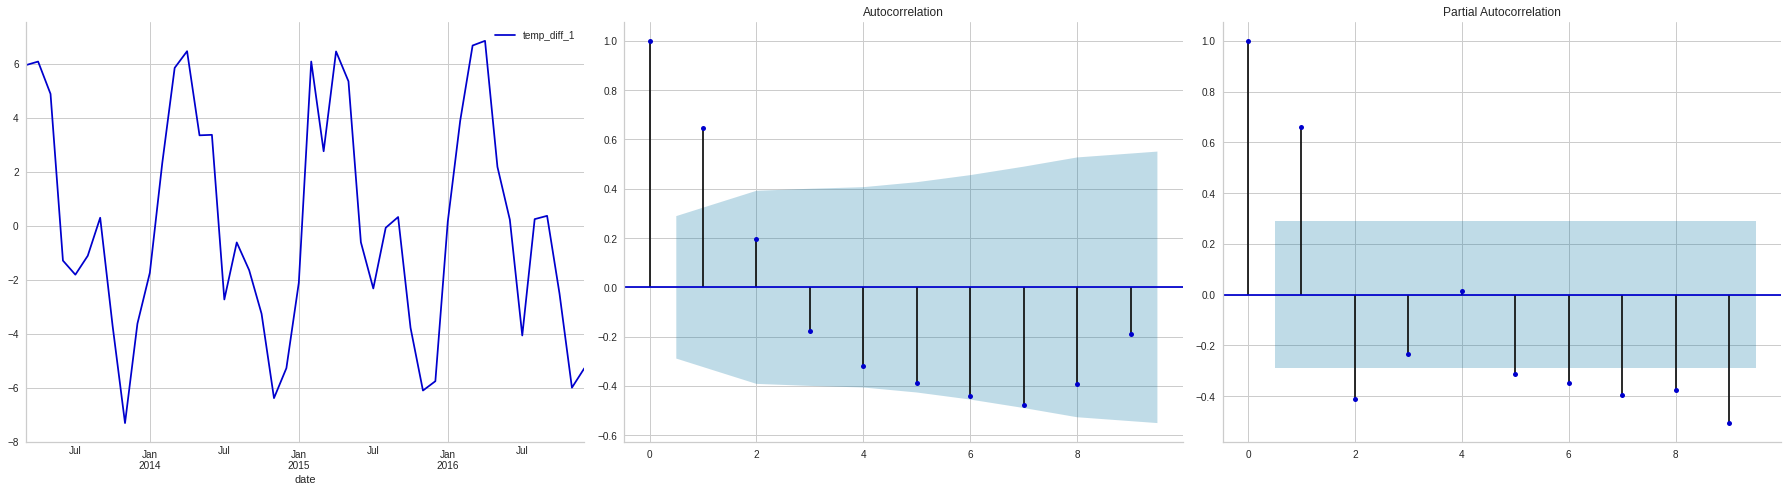

In [76]:
# First Order of Differencing
First_Order_Diff_df = get_diff(df, 0)

# Re-checking the staionarity of the data
adfuller_test(First_Order_Diff_df)
plots(First_Order_Diff_df, lags=number_of_lags)

Since we are able to receive the stationarity of the data just by applying the first order of differencing, but we will still check the Second and Third Order of Differencing in order to check better ACF and PACF plots.

ADF Test Statistic : -6.891540264355231
p-value : 1.3516857289312881e-09
Lags Used : 10
Number of Observations Used : 34

--> Strong evidence against the Null Hypothesis(Ho),
--> Reject the Null Hypothesis.
--> Data has no Unit Root and is Stationary



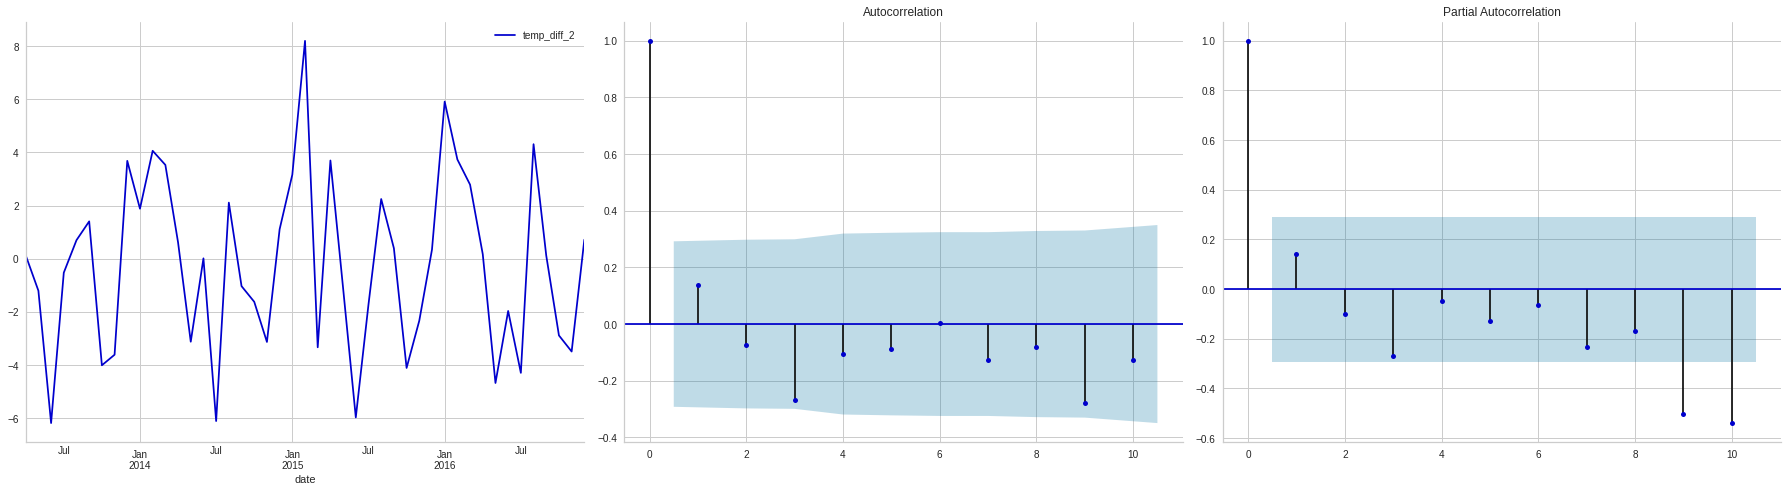

In [77]:
# Second Order of Differencing
Second_Order_Diff_df = get_diff(First_Order_Diff_df, 1)

# Re-checking the staionarity of the data
adfuller_test(Second_Order_Diff_df)
plots(Second_Order_Diff_df, lags=number_of_lags)

ADF Test Statistic : -5.732615177682352
p-value : 6.547206369933005e-07
Lags Used : 10
Number of Observations Used : 33

--> Strong evidence against the Null Hypothesis(Ho),
--> Reject the Null Hypothesis.
--> Data has no Unit Root and is Stationary



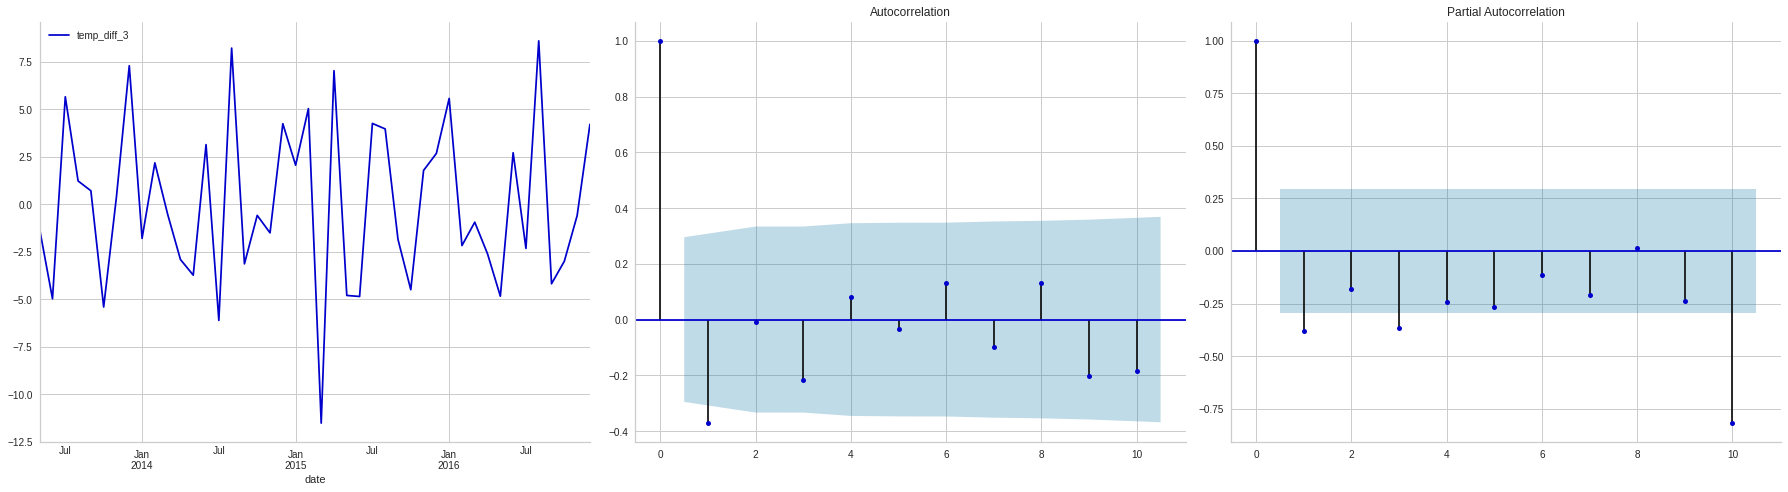

In [78]:
# Third Order of Differencing
Third_Order_Diff_df = get_diff(Second_Order_Diff_df, 2)

# Re-checking the staionarity of the data
adfuller_test(Third_Order_Diff_df)
plots(Third_Order_Diff_df, lags=number_of_lags)

After applying different order of differencing methods on the data, it is clearly observed that in Thrid Order of Differencing we started recieving Over-Differencing issue where as in the Second Order of Differencing we received all the lags lieing in In-Significance level and due to 2nd level of differencing we also started getting white noise.

Hence we will be considering First Order of Differencing where the mean is constant, standard deviation is constant and correlation is constant.

In [79]:
def generate_supervised(data):
    df = data.copy()
    
    #create column for each lag
    for i in range(1,10):
        col_name = 'lag_' + str(i)
        df[col_name] = df[data.columns[0]].shift(i)
    
    #drop null values
    df = df.dropna().reset_index(drop=True)

    return df

supervised_df = generate_supervised(First_Order_Diff_df)
supervised_df.columns

Index(['temp_diff_1', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_8', 'lag_9'],
      dtype='object')

# SARIMA Model

In [80]:
# Splitting the data into Training and Testing
SARIMA_X_train = First_Order_Diff_df.iloc[:32]
SARIMA_X_test = First_Order_Diff_df.iloc[32:]

In [81]:
# Applying SARIMA Model based on the observation of ACF and PACF Plot after the First Order of Differencing
# p = 1, d = 1, q = 1
SARIMA_Model = sm.tsa.statespace.SARIMAX(SARIMA_X_train,order=(1, 1, 1),seasonal_order=(1,1,0,12))
results = SARIMA_Model.fit(disp=-1)
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        temp_diff_1   No. Observations:                   32
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -37.283
Date:                            Thu, 04 Aug 2022   AIC                             82.566
Time:                                    11:49:05   BIC                             86.344
Sample:                                03-01-2013   HQIC                            83.206
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4234      0.404     -1.048      0.294      -1.215       0.368
ma.L1         -0.9973     23.953   

In [82]:
# Defined a customed function to compare various AIC values for different combinations of p, q and P, Q for d = 1, D = 1
# The combinations will be considerd only if the AIC value is less than the above AIC value i.e. 82.566
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm(parameters_list):
        try: 
            model = sm.tsa.statespace.SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 12

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

result_df = optimize_SARIMA(parameters_list, d, D, s, First_Order_Diff_df)
result_df

81


  0%|          | 0/81 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 2, 0)",129.742003
1,"(1, 2, 1, 0)",130.123373
2,"(0, 1, 1, 0)",131.769484
3,"(0, 2, 2, 0)",132.010651
4,"(0, 2, 1, 0)",132.309208
5,"(0, 1, 2, 0)",132.449554
6,"(1, 1, 2, 0)",132.455560
7,"(1, 1, 1, 0)",132.688618
8,"(2, 1, 2, 0)",134.341787
9,"(2, 1, 1, 0)",134.512325


In [83]:
# Since after checking the above combinations in the same order as shown, it is observed that least AIC values was obtained when p = 1, q = 2 and P = 1 and Q = 0
# Though we received the least AIC value till now but the "P" values of p, q and P, Q are more than significance values.
# Hence we will again perform other combinations but this time with the help of "auto_arima module" of "pmdarima library"
SARIMA_Model = sm.tsa.statespace.SARIMAX(SARIMA_X_train,order=(1, 1, 1),seasonal_order=(1,1,0,12))
results = SARIMA_Model.fit(disp=-1)
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        temp_diff_1   No. Observations:                   32
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -37.283
Date:                            Thu, 04 Aug 2022   AIC                             82.566
Time:                                    11:49:26   BIC                             86.344
Sample:                                03-01-2013   HQIC                            83.206
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4234      0.404     -1.048      0.294      -1.215       0.368
ma.L1         -0.9973     23.953   

### AUTO SARIMA Model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=103.831, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=90.183, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=96.715, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=85.683, Time=0.15 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=91.167, Time=0.05 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=inf, Time=nan sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=

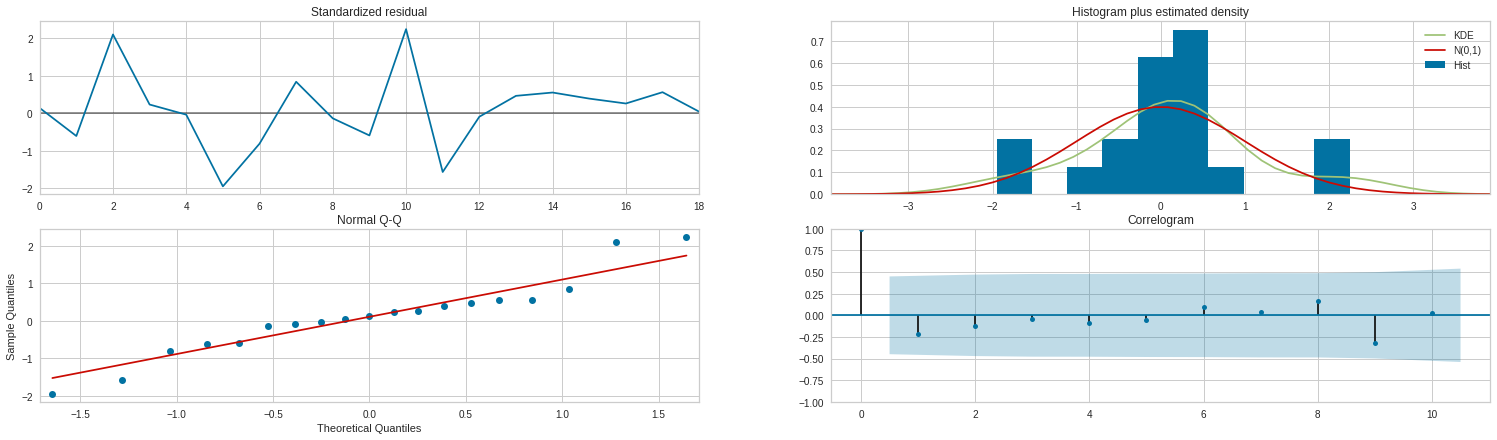

In [84]:
# Checking various combinations of p, q and P, Q with the help of "Auto_ARIMA Module" and by applying SARIMA model on the best combination.
! pip install pmdarima
import pmdarima as pm

SARIMA_Auto_Model = pm.auto_arima(SARIMA_X_train, start_p=0, max_p=3, start_q=0, max_q=3, d=1,
                                  m=12, seasonal=True, start_P=0, max_D=1, test='adf', trace=True,
                                  error_action='ignore', suppress_warnings=True, stepwise=True)
print(SARIMA_Auto_Model.summary())

SARIMA_Auto_Model.plot_diagnostics(figsize=(26,7))
plt.show()

RMSE: 1.3640371450227609
MAE: 1.0956939780546668
R2 Score: 0.9009615887866282


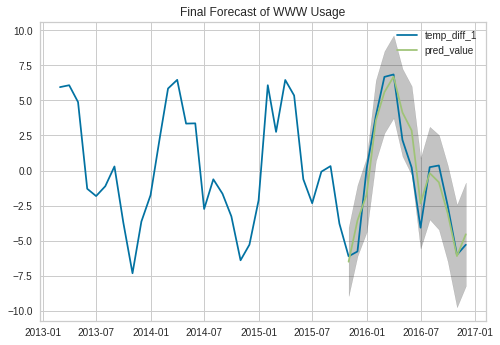

In [85]:
# Forecast
n_periods = 14
fc2, confint = SARIMA_Auto_Model.predict(n_periods=n_periods, return_conf_int=True)
# index_of_fc = np.arange(SARIMA_X_test.index[0], SARIMA_X_test.index[-1]+n_periods)
SARIMA_X_test['pred_value'] = fc2
get_sarima_scores(SARIMA_X_test)

# make series for plotting purpose
fc_series = pd.Series(fc2, index=SARIMA_X_test.index)
lower_series = pd.Series(confint[:, 0], index=SARIMA_X_test.index)
upper_series = pd.Series(confint[:, 1], index=SARIMA_X_test.index)

# Plot
plt.plot(First_Order_Diff_df)
plt.plot(SARIMA_X_test.pred_value)
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.25)

plt.title("Final Forecast of WWW Usage")
plt.legend(SARIMA_X_test.columns)
plt.show()

The above summary clearly stats that when AR (lag) = 3 then p-value is more than significance level, therfore we can try SARIMA model by considering p = 2 and q = 0, P = 1 and Q = 0

In [86]:
# Based on the above summary re-checking with values p = 2, q = 0 and P = 1, Q = 0 on SARIMA Model.
# Note: Objective is to receive all the p-values of AR, MA and SAR, SMA less than the Significance level.
SARIMA_Model = sm.tsa.statespace.SARIMAX(SARIMA_X_train,order=(2, 1, 0),seasonal_order=(1, 1, 0, 12))
results = SARIMA_Model.fit(disp=-1)
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        temp_diff_1   No. Observations:                   32
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -38.842
Date:                            Thu, 04 Aug 2022   AIC                             85.683
Time:                                    11:49:34   BIC                             89.461
Sample:                                03-01-2013   HQIC                            86.323
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9353      0.261     -3.582      0.000      -1.447      -0.423
ar.L2         -0.5668      0.157   

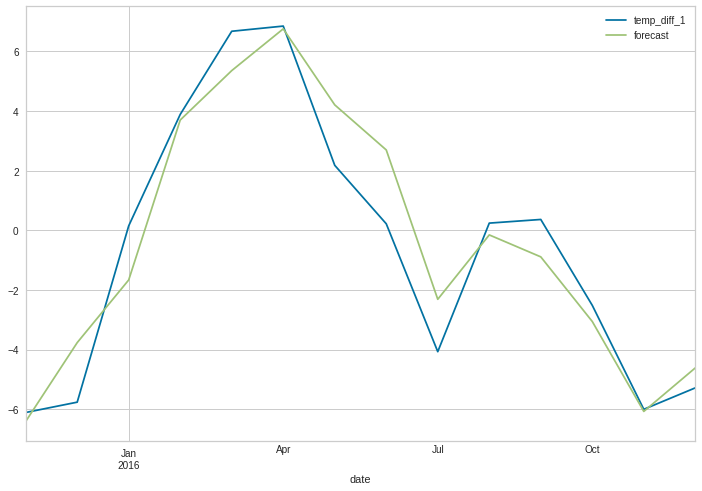

In [87]:
SARIMA_X_test['forecast']=results.predict(start=SARIMA_X_test.index[0],end=SARIMA_X_test.index[-1],dynamic=True)
SARIMA_X_test[['temp_diff_1','forecast']].plot(figsize=(12,8))

RMSE: 1.3353957047967606
MAE: 1.064617878670318
R2 Score: 0.9050770513149856


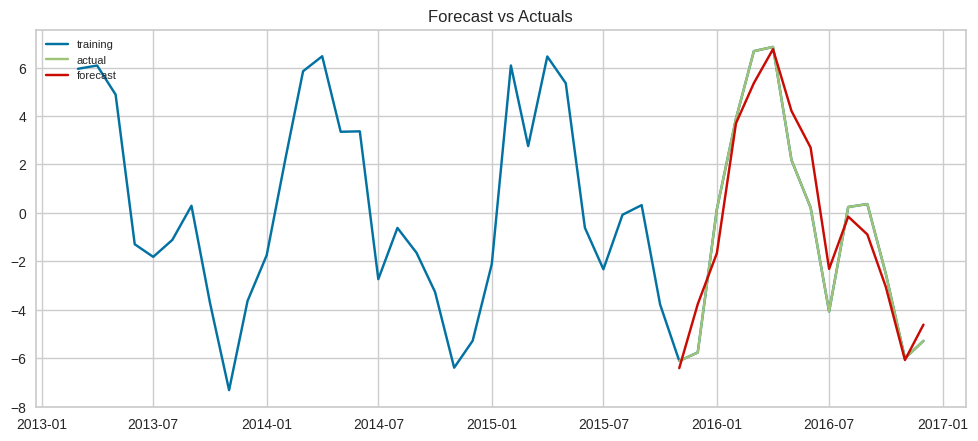

In [88]:
# Forecast
fc = results.forecast(14, alpha=0.05)  # 95% conf

SARIMA_X_test['pred_value'] = fc
get_sarima_scores(SARIMA_X_test)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(First_Order_Diff_df, label='training')
plt.plot(SARIMA_X_test.temp_diff_1, label='actual')
plt.plot(fc, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Prophet Model

In [89]:
Prophet_df = pd.read_csv("/content/drive/MyDrive/Time Series /Weather Forecasting Dataset from Kaggle/DailyDelhiClimateTrain.csv")
Prophet_df = monthly_avg_temperature(Prophet_df[:-1])
Prophet_monthly_df = get_diff(Prophet_df, 0, True)
Prophet_df.columns = ['ds', 'y']
Prophet_df
Prophet_Model = Prophet()
Prophet_Model.fit(Prophet_df)

11:49:34 - cmdstanpy - INFO - Chain [1] start processing
11:49:35 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
Future_Predictions = Prophet_Model.make_future_dataframe(periods=24, freq='MS')
Future_Predictions.tail()

,ds
67,2018-08-01
68,2018-09-01
69,2018-10-01
70,2018-11-01
71,2018-12-01


In [91]:
Prophet_Forecast = Prophet_Model.predict(Future_Predictions)
Prophet_Forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
67,2018-08-01,29.933184,33.613428,35.442457,29.660090,30.178949,4.585164,4.585164,4.585164,4.585164,4.585164,4.585164,0.0,0.0,0.0,34.518348
68,2018-09-01,30.041560,33.291682,35.156793,29.747721,30.309288,4.223509,4.223509,4.223509,4.223509,4.223509,4.223509,0.0,0.0,0.0,34.265069
69,2018-10-01,30.146440,29.896953,31.740925,29.834975,30.433626,0.672039,0.672039,0.672039,0.672039,0.672039,0.672039,0.0,0.0,0.0,30.818479
70,2018-11-01,30.254816,23.509043,25.353465,29.924069,30.563219,-5.788279,-5.788279,-5.788279,-5.788279,-5.788279,-5.788279,0.0,0.0,0.0,24.466537
71,2018-12-01,30.359696,18.435725,20.329715,30.006796,30.689750,-10.949052,-10.949052,-10.949052,-10.949052,-10.949052,-10.949052,0.0,0.0,0.0,19.410644


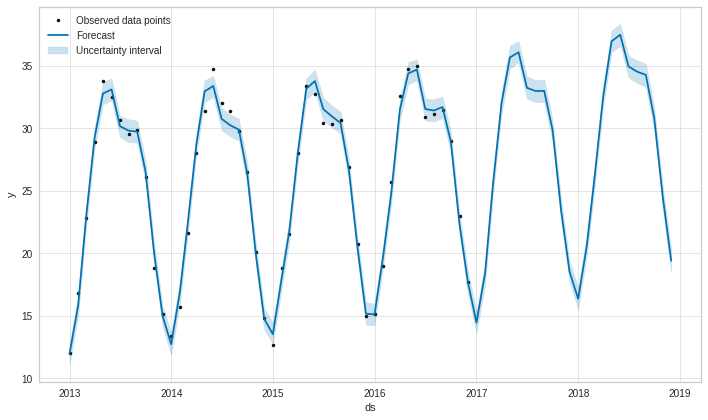

In [92]:
from matplotlib import legend
fig1 = Prophet_Model.plot(Prophet_Forecast,include_legend=True)

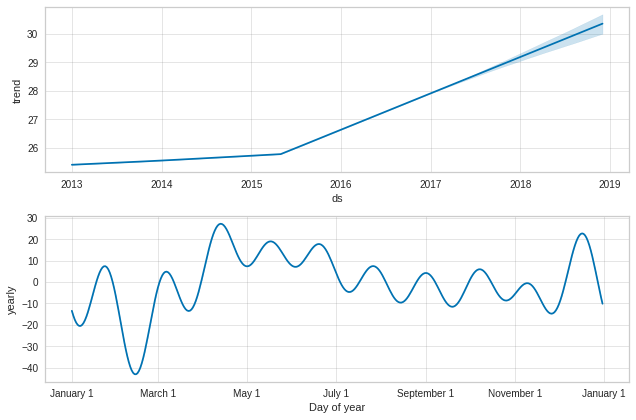

In [93]:
fig2 = Prophet_Model.plot_components(Prophet_Forecast)

# Supervised ML Models
### --> Linear Regression
### --> Randome Forest
### --> XGBooster
### --> Long Short Term Memory (LSTM)

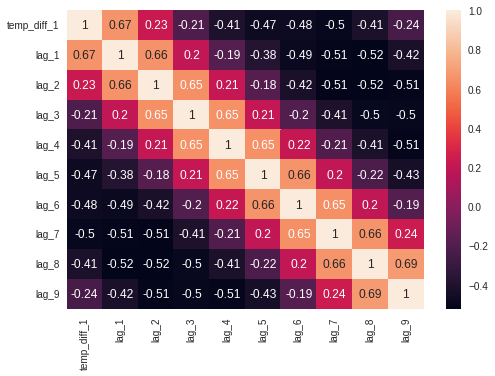

In [94]:
# Check the co-relation within the features
sns.heatmap(supervised_df.corr(), annot=True)

In [95]:
def load_original_df():
  #load in original dataframe
  original_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Weather Forecasting Dataset from Kaggle/DailyDelhiClimateTrain.csv")
  original_df = monthly_avg_temperature(original_df[:-1])
  return original_df

def tts(data):
  train, test = data[0:-11].values, data[-11:].values
  
  return train, test

def predict_df(predictions, original_df):
  #create dataframe that shows the predicted temp
  result_list = []
  temp_months = list(original_df[-14:].date)
  act_temp = list(original_df[-14:].meantemp)
  
  for index in range(0,len(predictions)):
    result_dict = {}
    result_dict['pred_value'] = int(predictions[index] + act_temp[index])
    result_dict['date'] = temp_months[index]
    result_list.append(result_dict)
      
  df_result = pd.DataFrame(result_list)
    
  return df_result

def plot_results(results, original_df, model_name):
  fig, ax = plt.subplots(figsize=(25,8))
  sns.lineplot(original_df.date, original_df.meantemp, data=original_df, ax=ax, label='Original', color='mediumblue')
  sns.lineplot(results.date, results.pred_value, data=results, ax=ax, label='Predicted', color='Red')
  
  ax.set(xlabel = "date", ylabel = "meantemp", title = f"{model_name} temp Forecasting Prediction")
  
  ax.legend()  
  sns.despine()

def run_model(train_data, test_data, model, model_name):
  X_train, y_train = train_data[:,1:], train_data[:,0:1]
  X_test, y_test = test_data[:,1:], test_data[:,0:1]
  
  mod = model
  mod.fit(X_train, y_train)
  predictions = mod.predict(X_test)

  # Undo scaling to compare predictions against original data
  original_df = load_original_df()
  df = predict_df(predictions, original_df)

  rmse = np.sqrt(mean_squared_error(y_test, predictions))
  mae = mean_absolute_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)
  model_scores[model_name] = [rmse, mae, r2]

  print(f"\n{model_name}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R2 Score: {r2}")
  
  plot_results(df, original_df, model_name)

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  X, Y = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    X.append(a)
    Y.append(dataset[i + look_back, 0])

  return np.array(X), np.array(Y)

# Converting a dictionary into data frame and sorting in descending order of RMSE
def create_results_df():    
  restults_df = pd.DataFrame.from_dict(model_scores, orient='index', columns=['RMSE', 'MAE','R2'])    
  restults_df = restults_df.sort_values(by='RMSE', ascending=False).reset_index()
  
  return restults_df

In [96]:
def lstm_model(train_data, test_data):  
  # reshape into X=t and Y=t+1
  look_back = 4
  X_train, y_train = create_dataset(train_data, look_back)
  X_test, y_test = create_dataset(test_data, look_back)

  # reshape input to be [samples, time steps, features]
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

  model = Sequential()
  model.add(LSTM(1, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False)
  predictions = model.predict(X_test,batch_size=1)

  original_df = load_original_df()
  df = predict_df(predictions, original_df)

  rmse = np.sqrt(mean_squared_error(y_test, predictions))
  mae = mean_absolute_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)
  model_scores['LSTM'] = [rmse, mae, r2]

  print(f"\n{'LSTM'}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R2 Score: {r2}")

  plot_results(df, original_df, 'LSTM')


LinearRegression
RMSE: 1.6019847001386651
MAE: 1.3664924512768284
R2 Score: 0.8573298237804745


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished



RandomForest
RMSE: 2.1472266676208154
MAE: 1.8707105734827691
R2 Score: 0.7436860436917674

XGBoost
RMSE: 1.2751389446020882
MAE: 1.075249828200211
R2 Score: 0.9096076890703343
Epoch 1/200
21/21 [==============================] - 2s 2ms/step - loss: 14.9337
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 14.8373
Epoch 3/200
21/21 [==============================] - 0s 2ms/step - loss: 14.7564
Epoch 4/200
21/21 [==============================] - 0s 2ms/step - loss: 14.6711
Epoch 5/200
21/21 [==============================] - 0s 2ms/step - loss: 14.5799
Epoch 6/200
21/21 [==============================] - 0s 2ms/step - loss: 14.4820
Epoch 7/200
21/21 [==============================] - 0s 4ms/step - loss: 14.3767
Epoch 8/200
21/21 [==============================] - 0s 2ms/step - loss: 14.2631
Epoch 9/200
21/21 [==============================] - 0s 2ms/step - loss: 14.1409
Epoch 10/200
21/21 [==============================] - 0s 2ms/step - loss: 14.0094
Epoch 11/20

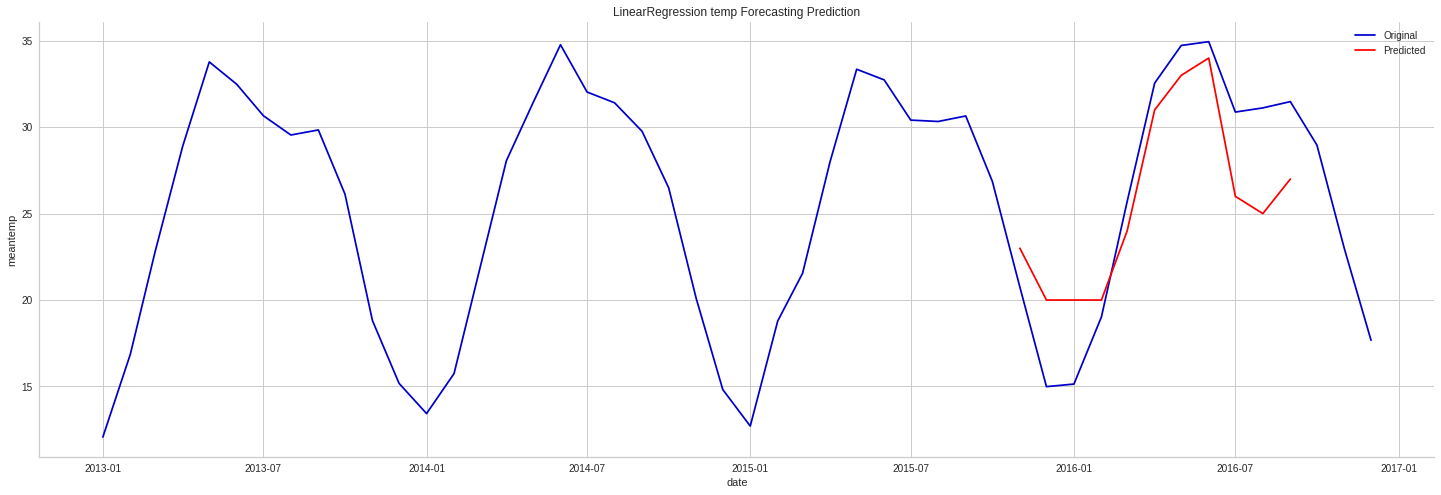

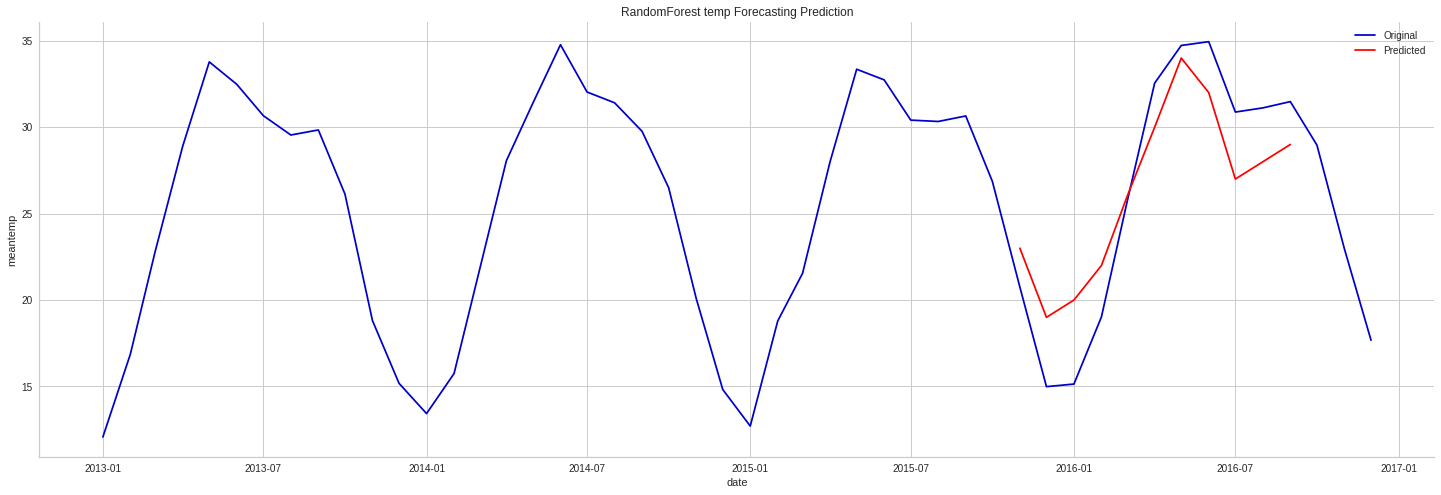

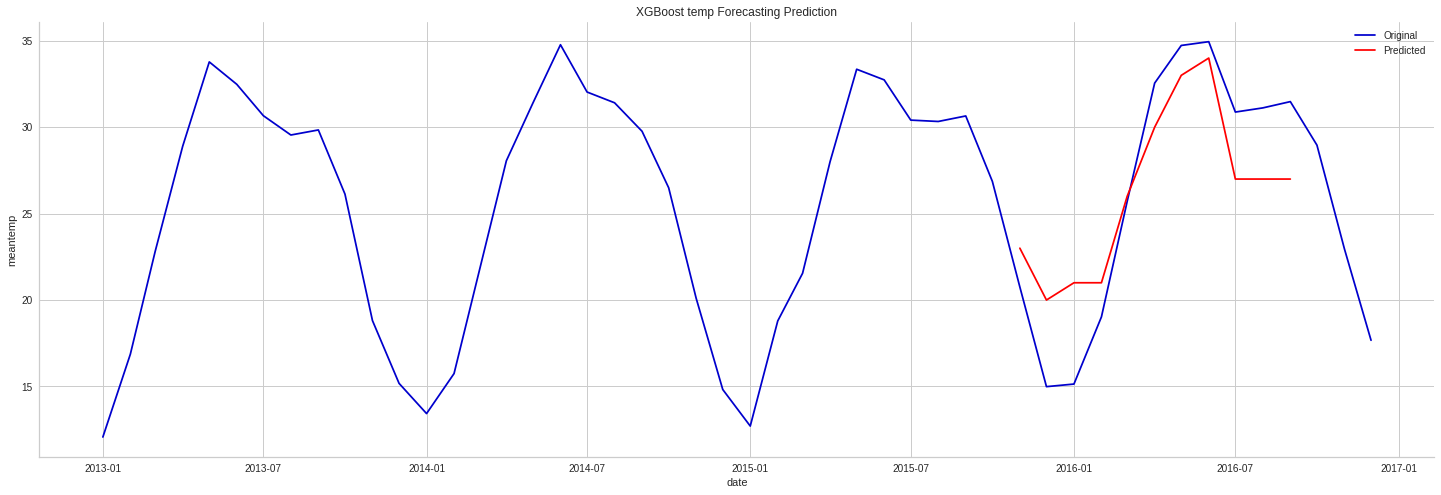

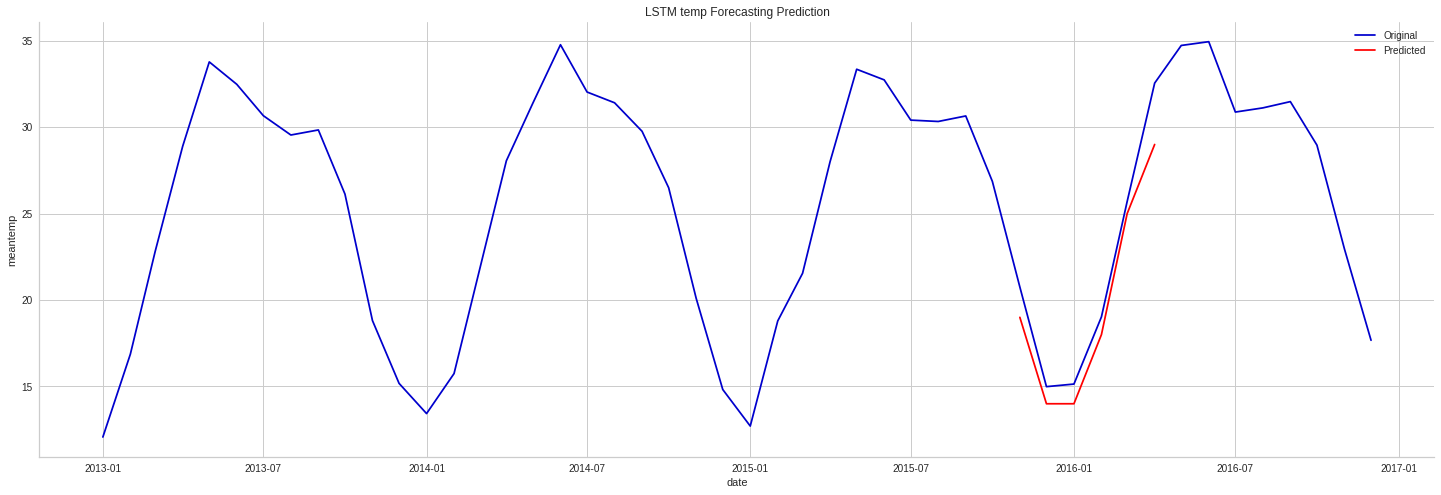

In [97]:
train, test = tts(supervised_df)

run_model(train, test, LinearRegression(), 'LinearRegression')
run_model(train, test, RandomForestRegressor(n_estimators=100, verbose=1, max_depth=20), 'RandomForest')
run_model(train, test, XGBRegressor( n_estimators=100, learning_rate=0.2, objective='reg:squarederror'), 'XGBoost')
lstm_model(train, test)

results = create_results_df()
print(results)

In [98]:
results = create_results_df()
print(results)

              index      RMSE       MAE        R2
0      RandomForest  2.147227  1.870711  0.743686
1              LSTM  2.104194  1.907010  0.264290
2  LinearRegression  1.601985  1.366492  0.857330
3            SARIMA  1.335396  1.064618  0.905077
4           XGBoost  1.275139  1.075250  0.909608


In [99]:
# install pycaret
! pip install pycaret
! pip install jinja2==2.11.3
! pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [109]:
# import the regression module
import jinja2
from pycaret.regression import *
from markupsafe import soft_unicode

#creating the train and validation set
train = supervised_df[:int(0.8*(len(supervised_df)))]
test = supervised_df[int(0.8*(len(supervised_df))):]

# initialize setup
s = setup(data = train, test_data = test, target = 'temp_diff_1', fold_strategy = 'timeseries', numeric_features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9'], fold = 5, feature_selection=True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,temp_diff_1
2,Original Data,"(29, 10)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(29, 9)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['lag_1', 'lag_2',
                                                          'lag_3', 'lag_4',
                                                          'lag_5', 'lag_6',
                                                          'lag_7', 'lag_8',
                                                          'lag_9'],
                                      target='temp_diff_1', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_availa...
                 Advanced_Feature_Selection_Classic(ml_usecase='regress

In [110]:
best = compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,1.8846,6.6109,2.3127,-0.3813,0.5614,1.6894,0.022
ada,AdaBoost Regressor,2.0521,5.8574,2.3156,-0.1587,0.6268,2.7911,0.080
gbr,Gradient Boosting Regressor,2.1884,6.4046,2.4296,-0.1311,0.6261,3.4639,0.044
rf,Random Forest Regressor,2.1945,6.9549,2.4404,-0.5103,0.7278,3.0185,0.476
br,Bayesian Ridge,2.2765,6.7773,2.5499,-0.2413,0.6964,2.5545,0.024
ridge,Ridge Regression,2.3630,7.6127,2.5785,-0.6238,0.6608,2.4071,0.030
lr,Linear Regression,2.4101,8.0719,2.6255,-0.7642,0.6647,2.4703,0.048
en,Elastic Net,2.3883,7.5041,2.6681,-0.4135,0.7167,2.3182,0.040
et,Extra Trees Regressor,2.4591,8.8108,2.7260,-0.9114,0.6817,2.4105,0.426
lasso,Lasso Regression,2.4586,8.3273,2.8047,-0.5833,0.7707,2.4056,0.036


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=123, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


In [111]:
print(results)

              index      RMSE       MAE        R2
0      RandomForest  2.147227  1.870711  0.743686
1              LSTM  2.104194  1.907010  0.264290
2  LinearRegression  1.601985  1.366492  0.857330
3            SARIMA  1.335396  1.064618  0.905077
4           XGBoost  1.275139  1.075250  0.909608


In [112]:
evaluate_model(best)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=123, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False), fold=None, fit_kwargs=None, plot_kwargs=None, feature_name=None, groups=None, use_train_data=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [113]:
predict_model(best)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=123, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Passive Aggressive Regressor,1.4874,5.1466,2.2686,0.3588,0.3257,0.777


,Component_1,Component_2,Component_3,Component_4,Component_5,Component_6,Component_7,Component_8,Component_9,temp_diff_1,Label
0,10.167066,-7.112575,-3.104463,-4.708644,-1.474458,1.168496,-0.848537,-2.161595,0.294994,2.178697,3.709840
1,12.287426,-0.011082,-7.296420,-0.942407,1.209184,1.421061,-1.798414,-0.167269,-1.209750,0.218110,0.587795
2,11.361148,8.021714,-4.223519,3.004295,1.262521,-0.567977,0.518270,-0.493417,1.013701,-4.071030,1.757788
3,5.253482,13.170623,0.743012,3.373327,0.243436,-0.939105,2.039477,1.808778,-1.973816,0.240771,0.341409
4,-0.896977,10.794650,6.412902,1.446306,-1.991152,-1.210060,-0.898776,0.294403,2.944050,0.363191,-0.008246
5,-5.625020,4.859297,6.835046,-2.891286,-0.955240,2.151593,-1.032876,-2.905261,-1.550705,-2.518088,-3.829403
6,-7.810928,0.731103,1.508117,-6.967704,1.770382,1.151827,-2.813466,0.462559,0.174592,-6.004302,-7.170176
7,-8.907513,-0.524895,-5.831655,-4.510650,1.005380,0.340839,1.841416,-1.844358,0.206073,-5.284814,-6.505385


In [114]:
predictions = predict_model(best, data=test)
predictions.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                           epsilon=0.1, fit_intercept=True,
                           loss='epsilon_insensitive', max_iter=1000,
                           n_iter_no_change=5, random_state=123, shuffle=True,
                           tol=0.001, validation_fraction=0.1, verbose=0,
                           warm_start=False), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Passive Aggressive Regressor,1.4874,5.1466,2.2686,0.3588,0.3257,0.777


,temp_diff_1,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,Label
29,2.178697,6.848954,6.675399,3.886314,0.149731,-5.764535,-6.111041,-3.784793,0.319211,-0.078773,3.709840
30,0.218110,2.178697,6.848954,6.675399,3.886314,0.149731,-5.764535,-6.111041,-3.784793,0.319211,0.587795
31,-4.071030,0.218110,2.178697,6.848954,6.675399,3.886314,0.149731,-5.764535,-6.111041,-3.784793,1.757788
32,0.240771,-4.071030,0.218110,2.178697,6.848954,6.675399,3.886314,0.149731,-5.764535,-6.111041,0.341409
33,0.363191,0.240771,-4.071030,0.218110,2.178697,6.848954,6.675399,3.886314,0.149731,-5.764535,-0.008246


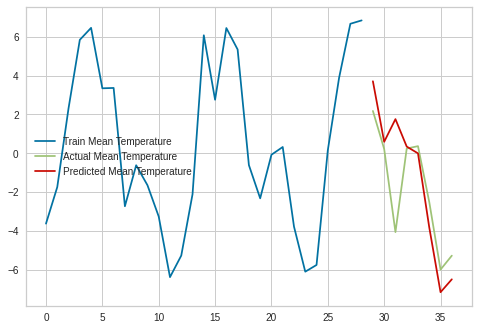

In [115]:
plt.plot(train.temp_diff_1, label="Train Mean Temperature")
plt.plot(predictions.temp_diff_1, label="Actual Mean Temperature")
plt.plot(predictions.Label, label="Predicted Mean Temperature")
plt.legend()
plt.show()